In [32]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

27524

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image


device = 'cuda'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 512) 
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

data = pd.read_csv('HAM10000_metadata_paths.csv')
mapping = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'bcc': 4, 'akiec': 5, 'vasc': 6}
X = data['image_path']
y = data['dx'].map(mapping)
print(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class HAM(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HAM(X_train, y_train, transform=transform)
val_dataset = HAM(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

0        0
1        0
2        0
3        0
4        0
        ..
10010    5
10011    5
10012    5
10013    5
10014    3
Name: dx, Length: 10015, dtype: int64


In [28]:
model = CNN().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda'
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
loss_fn = nn.CrossEntropyLoss()

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=2, device='cpu'):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs
            labels = labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs
                labels = labels
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # torch.save(model.state_dict(), 'cnn_model.pth')
    torch.save(model, 'basic_cnn.pkl')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [29]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, optimizer, loss_fn, train_loader, val_loader, epochs=2, device='cuda')
print(f'Training Losses: {train_losses}')
print(f'Training Accuracies: {train_accuracies}')
print(f'Validation Losses: {val_losses}')
print(f'Validation Accuracies: {val_accuracies}')

Epoch 1: Train Loss: 1.0118, Train Accuracy: 0.6655, Val Loss: 0.9292, Val Accuracy: 0.6695
Epoch 2: Train Loss: 0.8682, Train Accuracy: 0.6814, Val Loss: 0.9022, Val Accuracy: 0.6650
Training Losses: [1.0118362763488435, 0.8681643208659503]
Training Accuracies: [0.6655017473789316, 0.6813529705441838]
Validation Losses: [0.929244009275285, 0.9022378628216092]
Validation Accuracies: [0.6694957563654518, 0.6650024962556166]


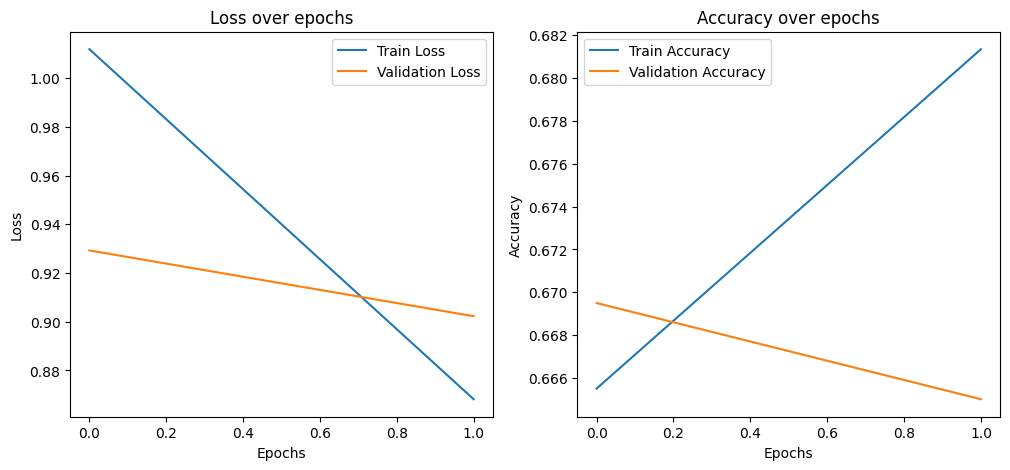

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()